## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №15

Решить задачу регрессии.  
Получить максимальную метрику качества (R2, RMSE).


### Введение

Целью данной задачи является прогнозирование суммы пятничных распродаж в магазинах сети Walmart с помощью построения регрессионных моделей и их анализа.  
Набор данных состоит из исторических данных, которые охватывают продажи с 2010-02-05 по 2012-11-01, предствленных в файле Walmart.csv



**Обзор доступных данных**

В наборе данных содержится 6435 наблюдений, 8 признаков для каждого. Пустые значения отсутвуют.

- Store - Номер магазина (the store number)
- Date - Дата пятницы, окончание недели распродаж (the week of sales)
- Weekly_Sales - Сумма продаж для данного магазина (sales for the given store)
- Holiday_Flag - Признак праздничной недели (whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week)
- Temperature - Температура в день распродаж (Temperature on the day of sale)
- Fuel_Price - Стоимость топлива в регионе (Cost of fuel in the region)
- CPI – Преобладающий индекс потредительских цен (Prevailing consumer price index)
- Unemployment - Преобладающий уровень безработицы (Prevailing unemployment rate)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from datetime import datetime 

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


DATA_CSV_PATH = 'Walmart.csv'

### Загрузка, анализ и преобразование данных

Загрузить данные: для признаков явно указываем требуемые типы

In [2]:
dtypes={
    'Store': 'uint8',
    'Date': 'object',
    'Weekly_Sales': float,
    'Holiday_Flag': 'uint8',
    'Temperature': float,
    'Fuel_Price': float,
    'CPI': float,
    'Unemployment': float
    }

df_raw = pd.read_csv(DATA_CSV_PATH , dtype = dtypes, sep=',')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   uint8  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   uint8  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), object(1), uint8(2)
memory usage: 314.3+ KB


Преобразовать дату в отдельные значения номера года, квартала, месяца и недели

In [3]:
date = pd.to_datetime(df_raw['Date'], dayfirst=True)

df_raw.insert(2, 'Date_year', (date.dt.year - 2000).astype('uint8'))
df_raw.insert(3, 'Date_quart', date.dt.quarter.astype('uint8'))
df_raw.insert(4, 'Date_month', date.dt.month.astype('uint8'))
df_raw.insert(5, 'Date_week', date.dt.isocalendar().week.astype('uint8'))

df_raw.drop(['Date'], inplace=True, axis=1)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   uint8  
 1   Date_year     6435 non-null   uint8  
 2   Date_quart    6435 non-null   uint8  
 3   Date_month    6435 non-null   uint8  
 4   Date_week     6435 non-null   uint8  
 5   Weekly_Sales  6435 non-null   float64
 6   Holiday_Flag  6435 non-null   uint8  
 7   Temperature   6435 non-null   float64
 8   Fuel_Price    6435 non-null   float64
 9   CPI           6435 non-null   float64
 10  Unemployment  6435 non-null   float64
dtypes: float64(5), uint8(6)
memory usage: 289.2 KB


Округление значений числовых признаков

In [4]:
df_raw[['Temperature','CPI','Unemployment']] = df_raw[['Temperature','CPI','Unemployment']].round().astype('int16')

df_raw[['Fuel_Price']] = df_raw[['Fuel_Price']].round(2).astype('float32')

#df_raw.info()

In [5]:
#df_raw['Unemployment'].value_counts()

<AxesSubplot:title={'center':'Сумма распродаж по неделям года'}, xlabel='Date_week', ylabel='Weekly_Sales'>

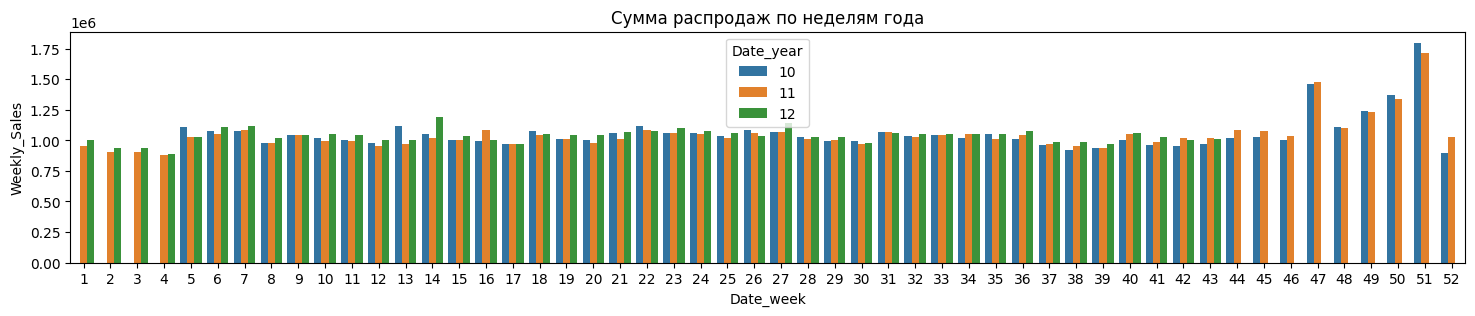

In [6]:
# Сумма распродаж по неделям года
plt.figure(figsize=(18,3))
plt.title('Сумма распродаж по неделям года')
sn.barplot (data = df_raw, x = 'Date_week', y = 'Weekly_Sales', hue='Date_year', ci = None)

<AxesSubplot:title={'center':'Сумма распродаж по неделям с учетом признака праздничных дней'}, xlabel='Date_week', ylabel='Weekly_Sales'>

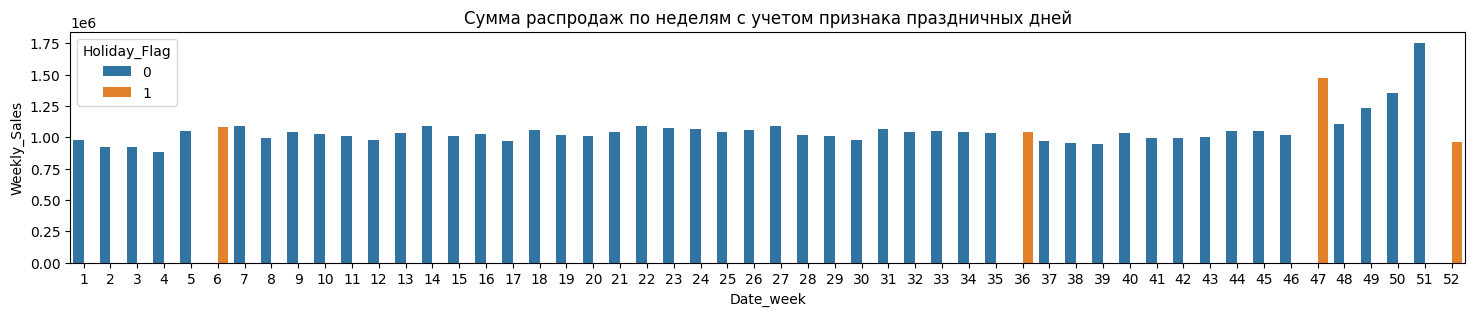

In [7]:
# Сумма распродаж по неделям с учетом признака праздничных дней
plt.figure(figsize=(18,3))
plt.title('Сумма распродаж по неделям с учетом признака праздничных дней')
sn.barplot (data = df_raw, x = 'Date_week', y = 'Weekly_Sales', hue='Holiday_Flag', ci = None)

<AxesSubplot:title={'center':'Сумма распродаж по праздничным и обычным дням'}, xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

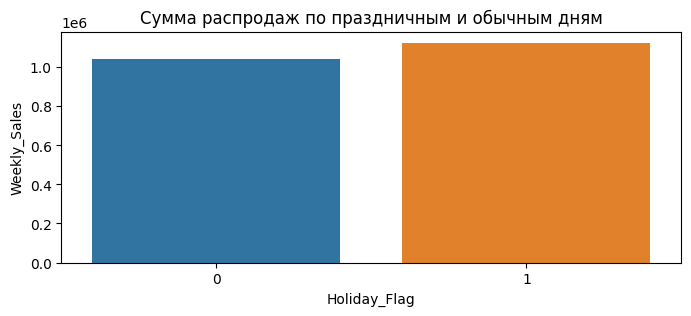

In [8]:
# Сумма распродаж по праздничным и обычным дням
plt.figure(figsize=(8,3))
plt.title('Сумма распродаж по праздничным и обычным дням')
sn.barplot (data = df_raw, x = 'Holiday_Flag', y = 'Weekly_Sales', ci = None)

<AxesSubplot:title={'center':'Сумма распродаж по магазинам'}, xlabel='Store', ylabel='Weekly_Sales'>

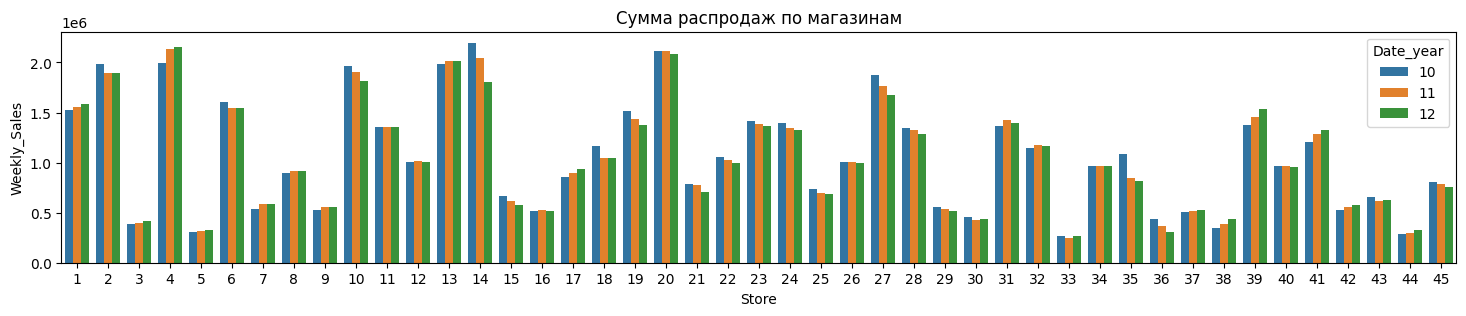

In [9]:
# Сумма распродаж по магазинам (регионам)
plt.figure(figsize=(18,3))
plt.title('Сумма распродаж по магазинам')
sn.barplot (data = df_raw, x = 'Store', y = 'Weekly_Sales', hue='Date_year', ci = None)

<AxesSubplot:title={'center':'Инфляция по регионам (магазинам)'}, xlabel='Store', ylabel='CPI'>

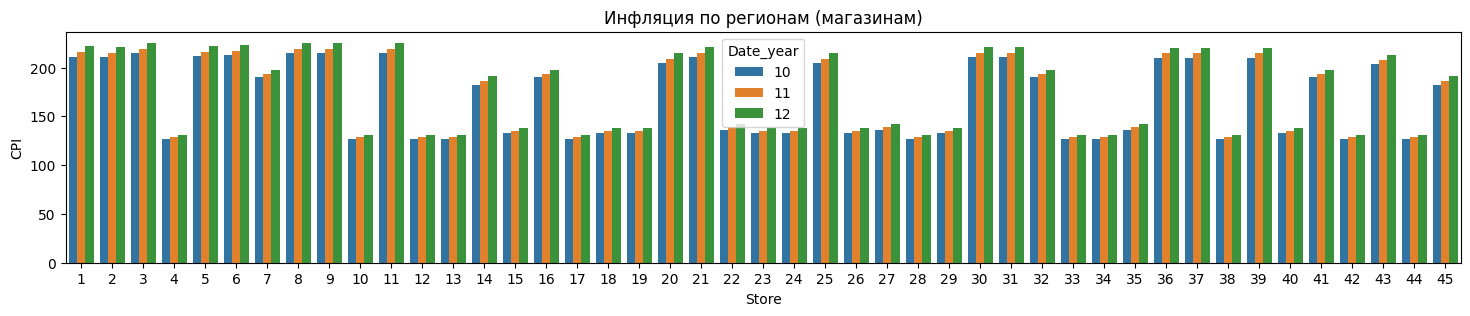

In [10]:
# Инфляция по регионам (магазинам)
plt.figure(figsize=(18,3))
plt.title('Инфляция по регионам (магазинам)')
sn.barplot (data = df_raw, x = 'Store', y = 'CPI', hue='Date_year', ci = None)

<AxesSubplot:title={'center':'Стоимость топлива по регионам (магазинам)'}, xlabel='Store', ylabel='Fuel_Price'>

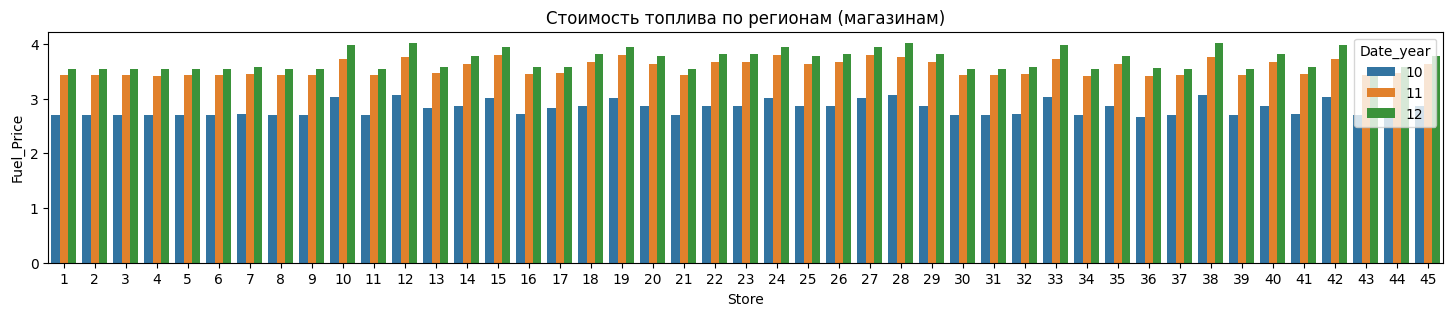

In [11]:
# Стоимость топлива по регионам (магазинам)
plt.figure(figsize=(18,3))
plt.title('Стоимость топлива по регионам (магазинам)')
sn.barplot (data = df_raw, x = 'Store', y = 'Fuel_Price', hue='Date_year', ci = None)

<AxesSubplot:title={'center':'Уровень безработицы по регионам (магазинам)'}, xlabel='Store', ylabel='Unemployment'>

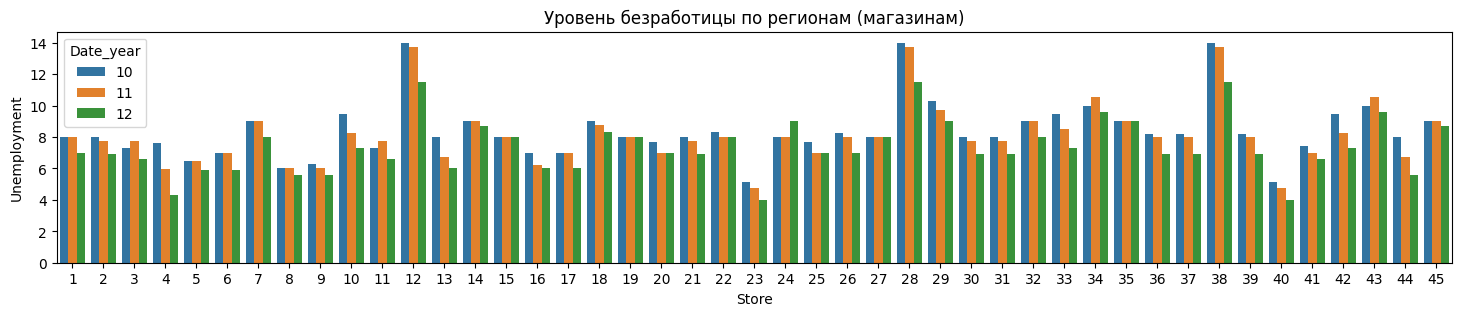

In [12]:
# Уровень безработицы по регионам (магазинам)
plt.figure(figsize=(18,3))
plt.title('Уровень безработицы по регионам (магазинам)')
sn.barplot (data = df_raw, x = 'Store', y = 'Unemployment', hue='Date_year', ci = None)

### Вариант 1: 
Категориальные признаки 'Store', 'Date_year', 'Date_quart', 'Date_month', 'Date_week', 'Holiday_Flag' оставить без изменений как LabelEncoded (кодируются отдельными значениями в одном столбце для соответствующих категорий)

Выполнить разбиение исходной выборки данных на 2 подмножества (обучение и тестирование)

In [13]:
y = df_raw['Weekly_Sales']
X = df_raw.drop(['Weekly_Sales'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

### Выполнить обучение и проверку моделей

#### 1. Linear Regression (вариант 1)

MAE: 433824.87,	 RMSE: 521878.49,	 R2:    0.15	 for Linear Regression model


Text(0, 0.5, 'Предсказанная сумма')

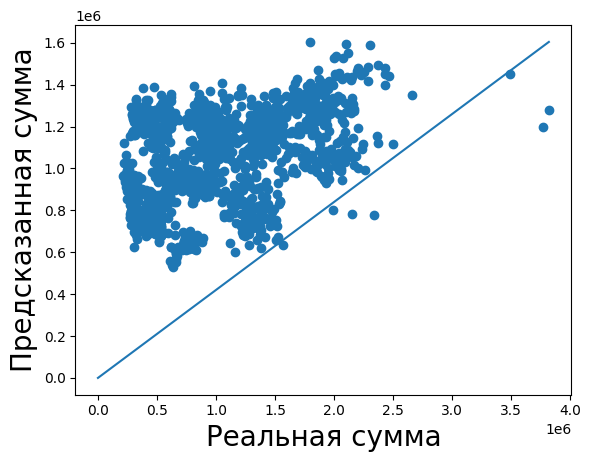

In [14]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2s = r2_score(y_test, lr_predictions)

print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Linear Regression model"
    .format(lr_mae, lr_mse**0.5, lr_r2s))

plt.scatter(y_test, lr_predictions) # точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(y_test)], [0, max(lr_predictions)])  # прямая, на которой предсказаные и реальные значения совпадают
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20)

#### 2. Polynomial Regression (вариант 1)

MAE: 382631.94,	 RMSE: 465293.60,	 R2:    0.33	 for Polynomial Regression model


Text(0, 0.5, 'Предсказанная сумма')

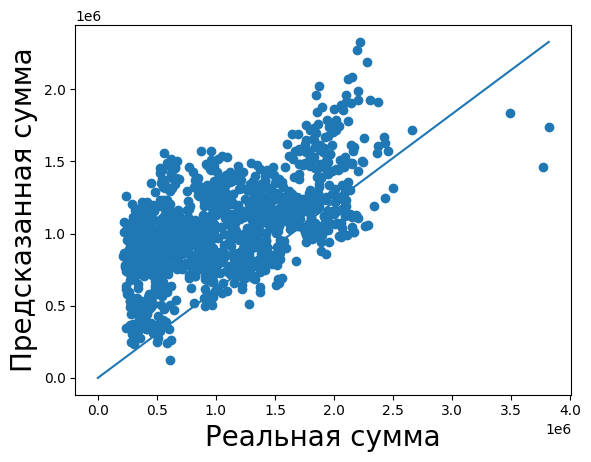

In [15]:
pr = make_pipeline(PolynomialFeatures(), LinearRegression(n_jobs=-1))
pr.fit(X_train, y_train)
pr_predictions = pr.predict(X_test)

pr_mae = mean_absolute_error(y_test, pr_predictions)
pr_mse = mean_squared_error(y_test, pr_predictions)
pr_r2s = r2_score(y_test, pr_predictions)

print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Polynomial Regression model"
        .format(pr_mae, pr_mse**0.5, pr_r2s))

plt.scatter(y_test, pr_predictions)
plt.plot([0, max(y_test)], [0, max(pr_predictions)])
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20)

#### 3. Random Forest Regression (вариант 1)

MAE: 60464.68,	 RMSE: 109397.56,	 R2:    0.96	 for Random Forest Regression model


Text(0, 0.5, 'Предсказанная сумма')

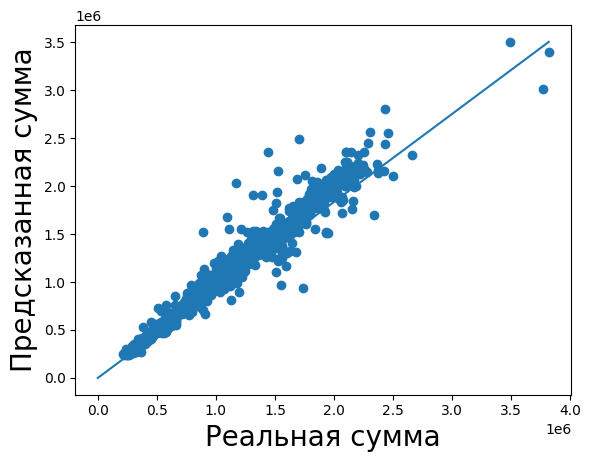

In [16]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2s = r2_score(y_test, rf_predictions)

print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Random Forest Regression model"
    .format(rf_mae, rf_mse**0.5, rf_r2s))

plt.scatter(y_test, rf_predictions)
plt.plot([0, max(y_test)], [0, max(rf_predictions)])
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20)

Построим диаграмму важности признаков для RandomForest

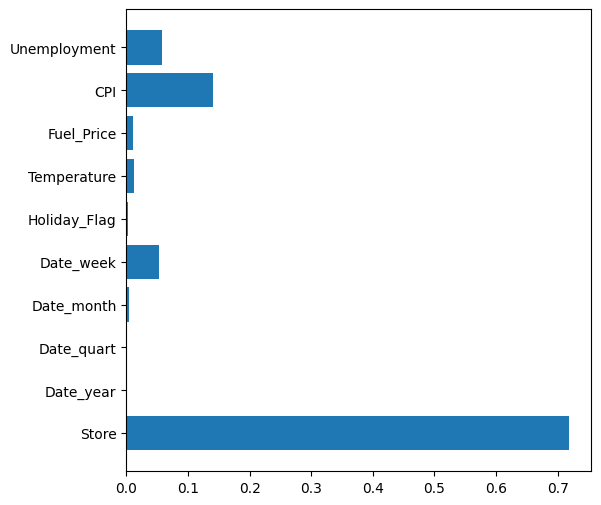

In [17]:
plt.figure(figsize=(6,6))
plt.barh(np.arange(len(rf.feature_importances_)), rf.feature_importances_)
plt.yticks(np.arange(len(X_train.columns)),X_train.columns);

Сравним метрики получившихся моделей:

In [18]:
print("1. MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Random Forest Regression model"
    .format(rf_mae, rf_mse**0.5, rf_r2s))
print("2. MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Polynomial Regression model "
    .format(pr_mae, pr_mse**0.5, pr_r2s))
print("3. MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Linear Regression model"
    .format(lr_mae, lr_mse**0.5, lr_r2s))

1. MAE: 60464.68,	 RMSE: 109397.56,	 R2:    0.96	 for Random Forest Regression model
2. MAE: 382631.94,	 RMSE: 465293.60,	 R2:    0.33	 for Polynomial Regression model 
3. MAE: 433824.87,	 RMSE: 521878.49,	 R2:    0.15	 for Linear Regression model


Выполним проверку полученных моделей с помошью Кросс-Валидации используя параметр оченки R2

In [19]:
from sklearn.model_selection import cross_val_score
models_v1_score = {}

scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
models_v1_score['Linear Regression'] = scores.mean()

scores = cross_val_score(pr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
models_v1_score['Polynomial Regression'] = scores.mean()

scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
models_v1_score['Random Forest'] = scores.mean()

[Text(0, 0, '0.144386'), Text(0, 0, '0.284217'), Text(0, 0, '0.960373')]

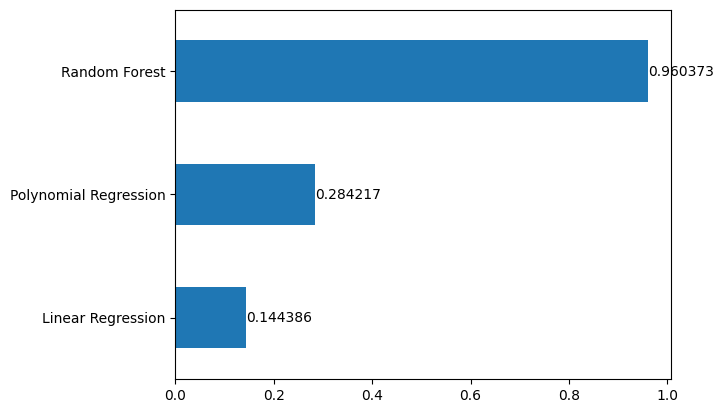

In [20]:
ax = pd.DataFrame.from_dict(data = models_v1_score, orient='index').plot(kind='barh', legend=False)
ax.bar_label(ax.containers[0])

### Вариант 2: 
Категориальные признаки 'Store', 'Date_year', 'Date_quart', 'Date_month', 'Date_week' преобразуем в разряженные массивы (OneHotEncoded),  
признак 'Holiday_Flag' -бинарный, оставляем без изменений как LabelEncoded

In [21]:
num_columns = ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']
cat_columns = ['Store', 'Date_year', 'Date_quart', 'Date_month', 'Date_week']

df_raw[['Store', 'Date_year', 'Date_quart', 'Date_month', 'Date_week']] = df_raw[['Store', 'Date_year', 'Date_quart', 'Date_month', 'Date_week']].astype('category')

df_num = df_raw[num_columns]
df_dummed = pd.get_dummies(df_raw[cat_columns])

df_cat = pd.concat((df_dummed, df_num), axis=1)
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Columns: 122 entries, Store_1 to Weekly_Sales
dtypes: float32(1), float64(1), int16(3), uint8(117)
memory usage: 848.5 KB


In [22]:
y = df_cat['Weekly_Sales']
X = df_cat.drop(['Weekly_Sales'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

#### 4. Linear Regression (вариант 2)

MAE: 73092.77,	 RMSE: 114883.97,	 R2:    0.96	 for Linear Regression model (OneHotEncoded)
MAE: 433824.87,	 RMSE: 521878.49,	 R2:    0.15	 for Linear Regression model (LabelEncoded)


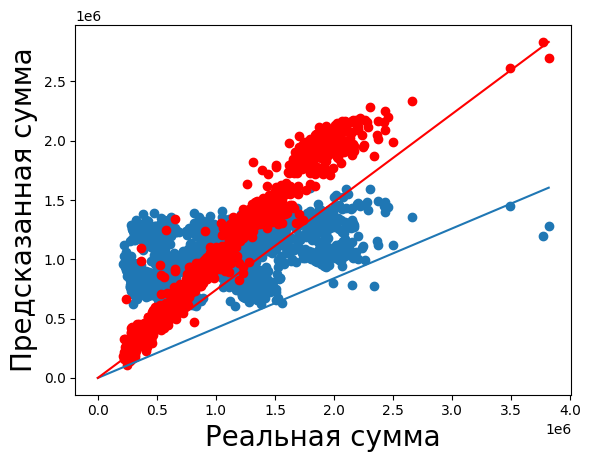

In [23]:
lr.fit(X_train, y_train)
lrc_predictions = lr.predict(X_test)

lrc_mae = mean_absolute_error(y_test, lrc_predictions)
lrc_mse = mean_squared_error(y_test, lrc_predictions)
lrc_r2s = r2_score(y_test, lrc_predictions)

print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Linear Regression model (OneHotEncoded)"
    .format(lrc_mae, lrc_mse**0.5, lrc_r2s))
print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Linear Regression model (LabelEncoded)"
    .format(lr_mae, lr_mse**0.5, lr_r2s))

plt.scatter(y_test, lr_predictions)
plt.scatter(y_test, lrc_predictions, color='r')
plt.plot([0, max(y_test)], [0, max(lr_predictions)])
plt.plot([0, max(y_test)], [0, max(lrc_predictions)], color='r')
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20);

#### 5. Polynomial Regression (вариант 2)

MAE: 382631.94,	 RMSE: 465293.60,	 R2:    0.33	 for Polynomial Regression model (LabelEncoded)
MAE: 45835.34,	 RMSE: 71559.72,	 R2:    0.98	 for Polynomial Regression model (OneHotEncoded)


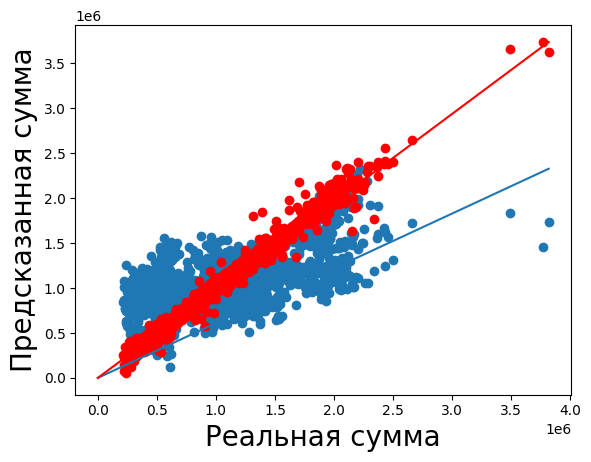

In [24]:
pr.fit(X_train, y_train)
prc_predictions = pr.predict(X_test)

prс_mae = mean_absolute_error(y_test, prc_predictions)
prс_mse = mean_squared_error(y_test, prc_predictions)
prс_r2s = r2_score(y_test, prc_predictions)

print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Polynomial Regression model (LabelEncoded)"
        .format(pr_mae, pr_mse**0.5, pr_r2s))
print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Polynomial Regression model (OneHotEncoded)"
        .format(prс_mae, prс_mse**0.5, prс_r2s))

plt.scatter(y_test, pr_predictions)
plt.scatter(y_test, prc_predictions, color='r')
plt.plot([0, max(y_test)], [0, max(pr_predictions)])
plt.plot([0, max(y_test)], [0, max(prc_predictions)], color='r')
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20);

#### 6. Random Forest Regression (вариант 2)

MAE: 60464.68,	 RMSE: 109397.56,	 R2:    0.96	 for Random Forest Regression model (LabelEncoded)
MAE: 55144.14,	 RMSE: 97473.46,	 R2:    0.97	 for Random Forest Regression model (OneHotEncoded)


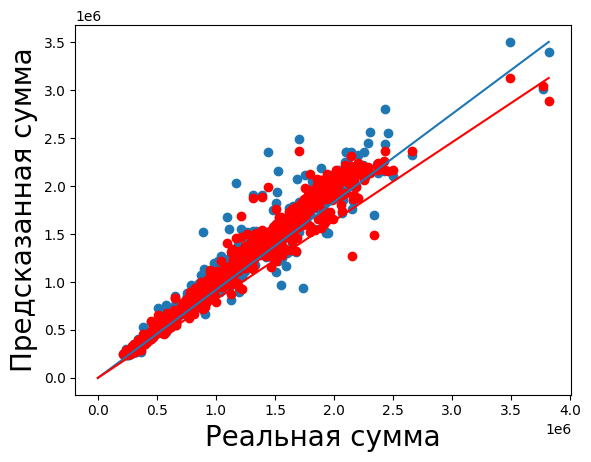

In [25]:
rf.fit(X_train, y_train)
rfc_predictions = rf.predict(X_test)

rfc_mae = mean_absolute_error(y_test, rfc_predictions)
rfc_mse = mean_squared_error(y_test, rfc_predictions)
rfc_r2s = r2_score(y_test, rfc_predictions)

print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Random Forest Regression model (LabelEncoded)"
    .format(rf_mae, rf_mse**0.5, rf_r2s))
print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for Random Forest Regression model (OneHotEncoded)"
    .format(rfc_mae, rfc_mse**0.5, rfc_r2s))

plt.scatter(y_test, rf_predictions)
plt.scatter(y_test, rfc_predictions, color='r')
plt.plot([0, max(y_test)], [0, max(rf_predictions)])
plt.plot([0, max(y_test)], [0, max(rfc_predictions)], color='r')
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20);

## Выводы

Отбразим метрики всех построенных моделей:

In [26]:
print("\nМетрики для Random Forest Regression model:")
print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t (OneHotEncoded)"
    .format(rfc_mae, rfc_mse**0.5, rfc_r2s))
print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t (LabelEncoded)"
    .format(rf_mae, rf_mse**0.5, rf_r2s))

print("\nМетрики для Polynomial Regression model:")
print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t (OneHotEncoded)"
        .format(prс_mae, prс_mse**0.5, prс_r2s))
print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t (LabelEncoded)"
        .format(pr_mae, pr_mse**0.5, pr_r2s))

print("\nМетрики для Linear Regression model:")
print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t (OneHotEncoded)"
    .format(lrc_mae, lrc_mse**0.5, lrc_r2s))
print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t (LabelEncoded)"
    .format(lr_mae, lr_mse**0.5, lr_r2s))


Метрики для Random Forest Regression model:
MAE: 55144.14,	 RMSE: 97473.46,	 R2:    0.97	 (OneHotEncoded)
MAE: 60464.68,	 RMSE: 109397.56,	 R2:    0.96	 (LabelEncoded)

Метрики для Polynomial Regression model:
MAE: 45835.34,	 RMSE: 71559.72,	 R2:    0.98	 (OneHotEncoded)
MAE: 382631.94,	 RMSE: 465293.60,	 R2:    0.33	 (LabelEncoded)

Метрики для Linear Regression model:
MAE: 73092.77,	 RMSE: 114883.97,	 R2:    0.96	 (OneHotEncoded)
MAE: 433824.87,	 RMSE: 521878.49,	 R2:    0.15	 (LabelEncoded)


1. Преобразование категориальных признаков в разряженную матрицу (One Hot Array) существенно улучшает метрики моделей Linear и Polinomial Regression.  
Причем алгоритм Linear Regression при наилучшей скорости обучения показывает на разряженных признаках точность, сравнимую с точностью других алгоритмов. 

2. Алгоритм Random Forest Regression показывет высокую точность на обоих наборах данных, применение "разряженных" признаков не дает сущесвенного улучшения метрик.

3. Алгоритм Polinomial Regression даже с параметрами по умолчанию показывает худшую скорость, но для разряженных данных лучшею точность

## Модели градиентного бустинга

#### XGBoost Regression

MAE: 49236.11,	 RMSE: 80793.46,	 R2:    0.98	 for XGBoost Regression model (OneHotEncoded)


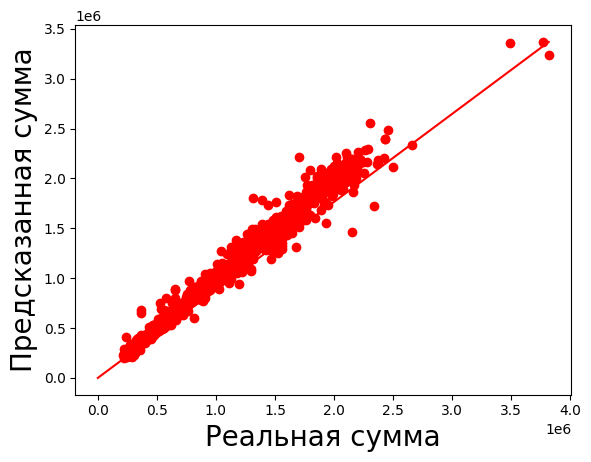

In [27]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_jobs=-1)
xgb.fit(X_train, y_train)

xgb_predictions = xgb.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2s = r2_score(y_test, xgb_predictions)

print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for XGBoost Regression model (OneHotEncoded)"
    .format(xgb_mae, xgb_mse**0.5, xgb_r2s))

plt.scatter(y_test, xgb_predictions, color='r')
plt.plot([0, max(y_test)], [0, max(xgb_predictions)], color='r')
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20);

#### CatBoost Regression

MAE: 51176.94,	 RMSE: 83757.77,	 R2:    0.98	 for CatBoost Regression model (OneHotEncoded)


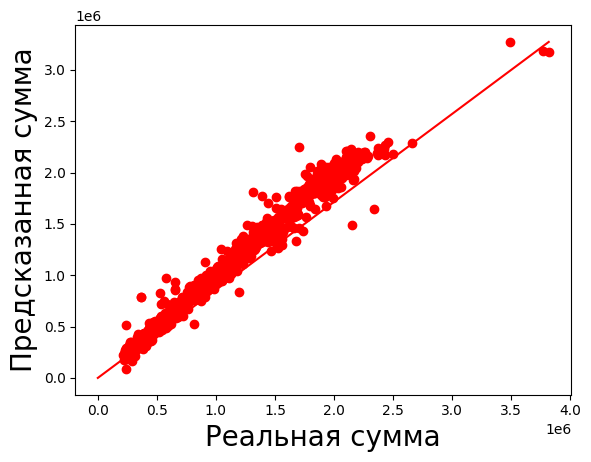

In [28]:
from catboost import CatBoostRegressor

cgb = CatBoostRegressor(verbose=False)
cgb.fit(X_train, y_train)

cgb_predictions = cgb.predict(X_test)

сgb_mae = mean_absolute_error(y_test, cgb_predictions)
сgb_mse = mean_squared_error(y_test, cgb_predictions)
сgb_r2s = r2_score(y_test, cgb_predictions)

print("MAE: {0:7.2f},\t RMSE: {1:7.2f},\t R2: {2:7.2f}\t for CatBoost Regression model (OneHotEncoded)"
    .format(сgb_mae, сgb_mse**0.5,сgb_r2s))

plt.scatter(y_test, cgb_predictions, color='r')
plt.plot([0, max(y_test)], [0, max(cgb_predictions)], color='r')
plt.xlabel('Реальная сумма', fontsize=20)
plt.ylabel('Предсказанная сумма', fontsize=20);

### Выполнить проверку полученных моделей с помощью Кросс-Валидации используя оценку R2

In [29]:
models_v2_score = {}

scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
models_v2_score['LinearRegression'] = scores.mean()

scores = cross_val_score(pr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
models_v2_score['PolynomialRegression'] = scores.mean()

scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
models_v2_score['RandomForestRegression'] = scores.mean()

scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
models_v2_score['XGBoostRegression'] = scores.mean()

scores = cross_val_score(cgb, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
models_v2_score['CatBoostRegression'] = scores.mean()

[Text(0, 0, '0.959427'),
 Text(0, 0, '0.978377'),
 Text(0, 0, '0.962142'),
 Text(0, 0, '0.973774'),
 Text(0, 0, '0.973203')]

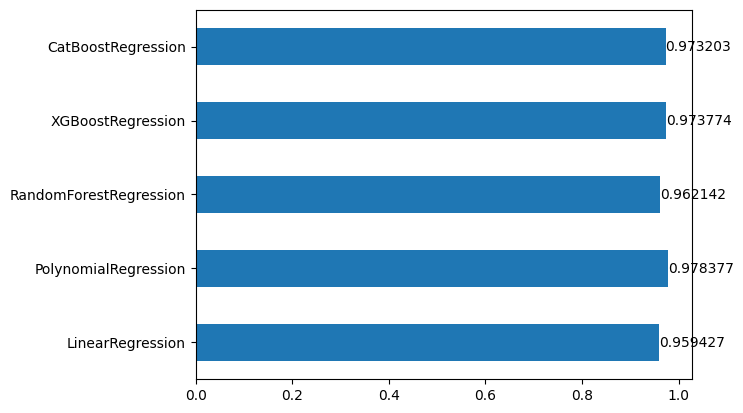

In [30]:
ax = pd.DataFrame.from_dict(data = models_v2_score, orient='index').plot(kind='barh', legend=False)
ax.bar_label(ax.containers[0])

## Супер вывод:

Алгоритм Polynomial Regression показывает лучшую точность на разряженных данных, без настройки гиперпараметров.  
Однако, данный алгоритм показывает наихудшую скорость и крайне высокие требования к ОЗУ, что на данной машине практически не позволяет выполнить подбор гиперпараметров модели.

Алгоритм Linear Regression, без дополнительных настроек показывает лучшую скорость работы, высокую точность, сравнимую с другими алгоритмами и при этом не требователем к ОЗУ.  
Однако и возможности по настройке модели практически отсутсвуют.

Алгоритмы Градиентного бустинга предлагают "золотую середину" по точности модели, скорости обучения и требовательности к ресурсам,  
и при этом имеют большое количество гиперпараметров позволяющих выполнить дополнительную настройку.